In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.utils import resample
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn import ensemble
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from sklearn import linear_model
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, confusion_matrix  
from IPython.display import Image
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn import preprocessing
from sklearn.linear_model import Ridge
import pydotplus
import graphviz
import os
import warnings
import random
from scipy import stats
warnings.filterwarnings('ignore')

In [2]:
os.chdir('C:\\Users\\liuth\Documents\\Python Scripts\\ThinkfulProjects\Data')

In [3]:
df = pd.read_csv('apft.csv')

---

Data Exploration and Visualization

In [4]:
df.head(5)

,CLASS,RN,SEX,AGE,RAW-PU,SCORE-PU,RAW-SU,SCORE-SU,TIME,SCORE-RU,SCORE,RESULT
0,12,101,M,19,64.0,90.0,67.0,82.0,1320.0,94.0,266.0,PASS
1,12,105,M,20,60.0,85.0,61.0,73.0,1525.0,66.0,224.0,PASS
2,12,106,M,20,64.0,90.0,55.0,63.0,1507.0,71.0,224.0,PASS
3,12,115,M,18,48.0,68.0,68.0,84.0,1518.0,68.0,220.0,PASS
4,12,116,M,23,70.0,94.0,55.0,67.0,1331.0,93.0,254.0,PASS


In [5]:
#Creating binary Results
df['RESULTBINARY'] = df['RESULT'].map(lambda i:1 if i == 'PASS' else 0)
df['SEXBINARY'] = df['SEX'].map(lambda i:1 if i == 'M' else 0)

In [6]:
df = df.fillna(0)

In [7]:
#Size of Sexbinary
female = df['SEXBINARY'].isin(['0'])
male = df['SEXBINARY'].isin(['1']) 
len(df.loc[female])

54

In [8]:
len(df.loc[male])

340

In [9]:
df['SEXBINARY'].shape

(394,)

In [10]:
df.dtypes

CLASS             int64
RN                int64
SEX              object
AGE               int64
RAW-PU          float64
SCORE-PU        float64
RAW-SU          float64
SCORE-SU        float64
TIME            float64
SCORE-RU        float64
SCORE           float64
RESULT           object
RESULTBINARY      int64
SEXBINARY         int64
dtype: object

In [11]:
#changing variables into objects/cleaning
df['CLASS'] = df['CLASS'].astype(int).astype(object)
df['RN'] = df['RN'].astype(int).astype(object)
df['TIME'] = df['TIME'].replace(['P', '#VALUE!', '#NA'], '')
df['SCORE'] = df['SCORE'].replace(['#N/A'], '')
df['SCORESU'] = df['SCORE-SU'].replace(['P', '#VALUE!','#N/A'], '')
df['SCOREPU'] = df['SCORE-PU'].replace(['P', '#VALUE!','#N/A'], '')
df['SCORERU'] = df['SCORE-RU'].replace(['P', '#VALUE!','#N/A'], '')
df['RAWPU'] = df['RAW-PU']
df['RAWSU'] = df['RAW-SU']

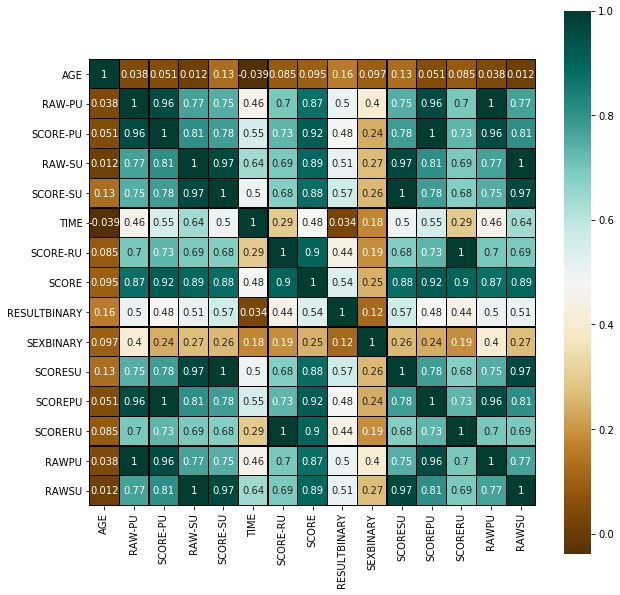

In [12]:
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(df.corr(), linewidths=0.1, square=True, cmap = "BrBG", linecolor='black', annot=True, ax=ax)

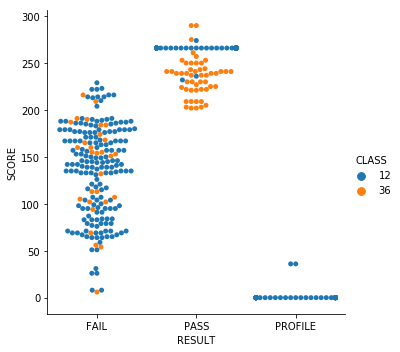

In [13]:
sns.catplot(data=df.loc[df['SCORE']]\
                               , x='RESULT', y='SCORE', hue='CLASS',
                               kind='swarm')

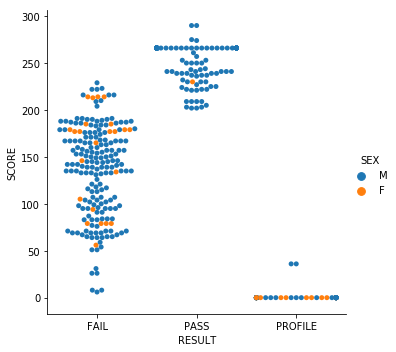

In [14]:
sns.catplot(data=df.loc[df['SCORE']]\
                               , x='RESULT', y='SCORE', hue='SEX',
                               kind='swarm')

In [15]:
#Class Imbalance, perhaps deal with it if exploring as a independent variable (SEX)

---

Verifying the 4 Assumptions for Linear Regression

In [16]:
im=smf.ols(formula='RESULTBINARY~SCORERU+SCORESU+AGE+RAWPU+RAWSU+SEXBINARY', data=df).fit()
#PCA the regression to fix the overfitting issue with the R^2

In [17]:
im.params
im.pvalues
im.rsquared
im.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           RESULTBINARY   R-squared:                       0.388
Model:                            OLS   Adj. R-squared:                  0.378
Method:                 Least Squares   F-statistic:                     40.86
Date:                Fri, 28 Jun 2019   Prob (F-statistic):           1.67e-38
Time:                        17:05:38   Log-Likelihood:                -44.872
No. Observations:                 394   AIC:                             103.7
Df Residuals:                     387   BIC:                             131.6
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0366      0.104     -0.353      0.724      -0.241       0.167
SCORERU        0.0006      0.001      1.019      0.309      -0.001       0.002
SCORESU        0.0156      0.002      6.681      0.000       0.011       0.020
AGE            0.0009      0.004      0.201      0.840      -0.008       0.009
RAWPU          0.0048      0.001      4.052      0.000       0.002       0.007
RAWSU         -0.0148      0.003     -4.780      0.000      -0.021      -0.009
SEXBINARY     -0.0833      0.045     -1.872      0.062      -0.171       0.004
==============================================================================
Omnibus:                       30.123   Durbin-Watson:                   0.550
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               35.720
Skew:                           0.737   Prob(JB):                     1.75e-08
Kurtosis:                       2.935   Cond. No.                         681.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

---

Down/Up Sampling

In [18]:
df2 = pd.DataFrame()

In [19]:
df2['RESULTBINARY'] = df['RESULTBINARY']
df2['SEXBINARY'] = df['SEXBINARY']
df2['SCORE-PU'] = df['SCOREPU']
df2['SCORE-SU'] = df['SCORESU']
df2['SCORE-RU'] = df['SCORERU']
df2['RAW-PU'] = df['RAWPU']
df2['SCORE'] = df['SCORE']
df2['AGE'] = df['AGE']
df2['RAW-SU']=df['RAWSU']

df2.shape

(394, 9)

In [20]:
#Downsample Testing
# Separate the majority and minority Class.
df_maj = df2[df2.RESULTBINARY==1]
df_min = df2[df2.RESULTBINARY==0]

# Downsample majority class 
df_maj_downsampled = resample(df_maj,
                                    replace=True,
                                    n_samples=len(df_min),
                                    random_state=123)
                               
# Combine minority class with downsampled majority class
df_downsampled = pd.concat([df_maj_downsampled, df_min])

df_downsampled.shape
df_downsampled.RESULTBINARY.value_counts()

1    339
0    339
Name: RESULTBINARY, dtype: int64

In [21]:
#Upsampling Testing
# Separate the majority and minority Class.
df_maj = df2[df2.SEXBINARY==1]
df_min = df2[df2.SEXBINARY==0]

# Downsample majority class 
df_maj_upsampled = resample(df_min,
                              replace=True,
                              n_samples=len(df_maj),
                              random_state=123)
                               
# Combine minority class with downsampled majority class
df_upsampled = pd.concat([df_maj_upsampled, df_maj])
df_upsampled.SEXBINARY.value_counts()

1    340
0    340
Name: SEXBINARY, dtype: int64

In [22]:
df_train_down,df_test_down= train_test_split(df_downsampled,test_size=0.20)
df_train_up,df_test_up= train_test_split(df_upsampled,test_size=0.20)

In [23]:
df_train_down.head(5)

,RESULTBINARY,SEXBINARY,SCORE-PU,SCORE-SU,SCORE-RU,RAW-PU,SCORE,AGE,RAW-SU
148,0,1,26.0,31.0,58.0,10.0,115.0,22,28.0
124,0,1,63.0,60.0,19.0,44.0,142.0,18,53.0
203,1,1,75.0,88.0,76.0,51.0,239.0,34,66.0
228,1,1,71.0,76.0,83.0,50.0,230.0,19,63.0
186,0,1,0.0,0.0,0.0,0.0,0.0,21,0.0


In [24]:
#Cleaning
df_train_down['SCORE-RU'] = df_train_down['SCORE-RU'].replace(['#VALUE!'], 0)
df_test_down['SCORE-RU'] = df_test_down['SCORE-RU'].replace(['#VALUE!'], 0)
df_train_down['SCORE'] = df_train_down['SCORE'].astype(str)
df_test_down['SCORE'] = df_test_down['SCORE'].astype(str)

In [25]:
df_train_down.dtypes

RESULTBINARY      int64
SEXBINARY         int64
SCORE-PU        float64
SCORE-SU        float64
SCORE-RU        float64
RAW-PU          float64
SCORE            object
AGE               int64
RAW-SU          float64
dtype: object

---

Visiting this through Logistics Regression

In [26]:
lr = LogisticRegression()

In [27]:
X = df_train_down[['RAW-PU', 'RAW-SU', 'SEXBINARY']] #justify the independent variables
Y = df_train_down['RESULTBINARY'] #discrete variable, changed to gender to see the possibilities of passing the initial APFT

# Use GS-CV to see which alpha level is best.
parameters = {
             'C':[0.00001,0.0001,0.001,0.01,0.1,1,10,100,10000,100000,100000000]}

lr_grid = GridSearchCV(lr, parameters, cv=5, verbose=1) 

#Fit the logistic regression 
lr_grid.fit(X, Y)

#return best parameters and best score
print('Best parameters:')
print(lr_grid.best_params_)
print('Best Score:')
print(lr_grid.best_score_)

Fitting 5 folds for each of 11 candidates, totalling 55 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Best parameters:
{'C': 10000}
Best Score:
0.9501845018450185


[Parallel(n_jobs=1)]: Done  55 out of  55 | elapsed:    0.3s finished


In [28]:
Xtest = df_test_down[['RAW-PU', 'RAW-SU','SEXBINARY']] #justify the independent variables
Ytest = df_test_down['RESULTBINARY'] #discrete variable, changed to gender to see the possibilities of passing the initial APFT

# Use GS-CV to see which alpha level is best.
parameters = {
             'C':[0.00001,0.0001,0.001,0.01,0.1,1,10,100,10000,100000,100000000]}

lr_grid = GridSearchCV(lr, parameters, cv=5, verbose=1) 

#Fit the logistic regression 
lr_grid.fit(Xtest, Ytest)

#return best parameters and best score
print('Best parameters:')
print(lr_grid.best_params_)
print('Best Score:')
print(lr_grid.best_score_)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 5 folds for each of 11 candidates, totalling 55 fits
Best parameters:
{'C': 100}
Best Score:
0.9338235294117647


[Parallel(n_jobs=1)]: Done  55 out of  55 | elapsed:    0.2s finished


In [29]:
lr = LogisticRegression(C=100)

# Fit the model.
fit = lr.fit(X, Y)
fit2 = lr.fit(Xtest, Ytest)

# Display.
print('Coefficients Train')
print(fit.coef_)
print(fit.intercept_)
pred_y_sklearn2 = lr.fit(X, Y) #done for estimation

print('Coefficients Test')
print(fit2.coef_)
print(fit2.intercept_)
pred_y_sklearn = lr.predict(Xtest) #predict what is going on for the estimation

print('\n Accuracy of PASS status')
print(pd.crosstab(pred_y_sklearn, Ytest))

print('\n Percentage accuracy')
print(lr.score(X, Y))

print('\n Percentage accuracy')
print(lr.score(Xtest, Ytest))

#class imbalance produces high accuracy, revisit after down sampling.

cross_val_score(lr, Xtest, Ytest, cv=5)

Coefficients Train
[[ 0.2483473   0.18086172 -6.74402677]]
[-14.09202514]
Coefficients Test
[[ 0.13793996  0.30632586 -2.06475369]]
[-19.81477025]

 Accuracy of PASS status
RESULTBINARY   0   1
row_0               
0             60   1
1              7  68

 Percentage accuracy
0.9520295202952029

 Percentage accuracy
0.9411764705882353


array([0.96428571, 1.        , 0.88888889, 0.92592593, 0.88461538])

---

Gradient Boosting due to overfitting issues (SEXBINARY)

Weak learner 0 R^2: 0.44649446494464945
Weak learner 20 R^2: 0.44649446494464945
Weak learner 40 R^2: 0.44649446494464945
Weak learner 60 R^2: 0.44649446494464945
Weak learner 80 R^2: 0.44649446494464945
Weak learner 100 R^2: 0.44649446494464945


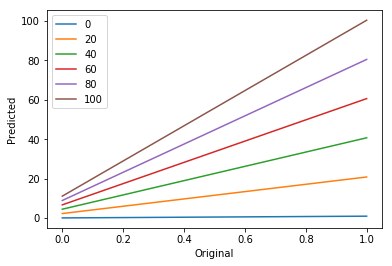

Overall R^2:
0.8867043059052068


In [30]:
preds = pd.DataFrame()
labels = []

uniquex = df_train_down['RESULTBINARY'].unique()
for m in range(0, 101):
    
    # Initialize and fit the tree. Set the max depth to 2.
    log_reg = LogisticRegression()
    log_reg.fit(X, Y)
    
    # Get and store predicted values.
    pred = log_reg.predict(X)
    preds['pred{}'.format(m)] = pred
    
    # Residuals.
    y = Y - pred

    # Output every 20 iterations.
    if m % 20 == 0:
        print('Weak learner {} R^2: {}'.format(m, log_reg.score(X, y)))
        labels = labels + [m]
        bestpred = preds.sum(axis=1)
        plt.plot(uniquex, np.poly1d(np.polyfit(df_train_down['RESULTBINARY'], bestpred, 1))(uniquex))
       
plt.legend(labels)
plt.xlabel('Original')
plt.ylabel('Predicted')
plt.show()
predicted = preds.sum(axis=1)

print('Overall R^2:')
print(np.corrcoef(df_train_down['RESULTBINARY'], predicted)[0, 1])

Weak learner 0 R^2: 0.4117647058823529
Weak learner 20 R^2: 0.4117647058823529
Weak learner 40 R^2: 0.4117647058823529
Weak learner 60 R^2: 0.4117647058823529
Weak learner 80 R^2: 0.4117647058823529
Weak learner 100 R^2: 0.4117647058823529


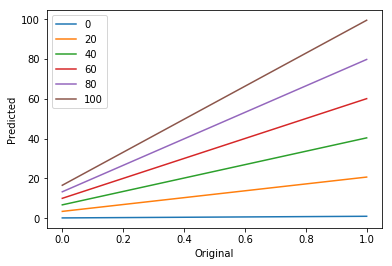

Overall R^2:
0.8321999338569136


In [31]:
preds2 = pd.DataFrame()
labels2 = []
uniquex2 = df_test_down['RESULTBINARY'].unique()

for m in range(0, 101):
    
    # Initialize and fit the tree. Set the max depth to 2.
    logger = LogisticRegression()
    logger.fit(Xtest, Ytest)
    
    # Get and store predicted values.
    pred2 = logger.predict(Xtest)
    preds2['pred{}'.format(m)] = pred2
    
    # Residuals.
    ytest = Ytest - pred2

    # Output every 20 iterations.
    if m % 20 == 0:
        print('Weak learner {} R^2: {}'.format(m, logger.score(Xtest, ytest)))
        labels2 = labels + [m]
        bestpred2 = preds2.sum(axis=1)
        plt.plot(uniquex2, np.poly1d(np.polyfit(df_test_down['RESULTBINARY'], bestpred2, 1))(uniquex2))
       
plt.legend(labels2)
plt.xlabel('Original')
plt.ylabel('Predicted')
plt.show()
predicted = preds2.sum(axis=1)

print('Overall R^2:')
print(np.corrcoef(df_test_down['RESULTBINARY'], predicted)[0, 1])

In [32]:
params = {'n_estimators': 500,
          'max_depth': 2,
          'loss': 'deviance'}

# Initialize and fit the model.
clf = ensemble.GradientBoostingClassifier(**params)
clf.fit(X, Y)

predict_train = clf.predict(X)
predict_test = clf.predict(Xtest)

# Accuracy tables.
table_train = pd.crosstab(Y, predict_train, margins=True)
table_test = pd.crosstab(Ytest, predict_test, margins=True)

train_tI_errors = table_train.loc[0.0,1.0] / table_train.loc['All','All']
train_tII_errors = table_train.loc[1.0,0.0] / table_train.loc['All','All']

test_tI_errors = table_test.loc[0.0,1.0]/table_test.loc['All', 'All']
test_tII_errors = table_test.loc[1.0,0.0]/table_test.loc['All','All']

print((
    'Training set accuracy:\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}\n\n'
    'Test set accuracy:\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}'
).format(train_tI_errors, train_tII_errors, test_tI_errors, test_tII_errors))


Training set accuracy:
Percent Type I errors: 0.0
Percent Type II errors: 0.0

Test set accuracy:
Percent Type I errors: 0.029411764705882353
Percent Type II errors: 0.0


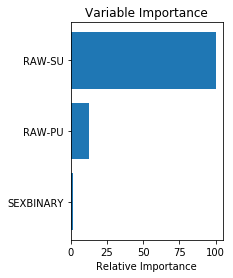

In [33]:
feature_importance = clf.feature_importances_

# Make importances relative to max importance.
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

In [34]:
#Time to apply shrinkage, I cannot keep removing independent variables
lass = linear_model.Lasso(alpha=.35)
lassfit = lass.fit(X, Y)
print('R² for the model with training model:')
print(lass.score(X, Y))
origparams = np.append(lassfit.coef_, lassfit.intercept_)
print('\nParameter estimates for the model with few features:')
print(origparams)

# Large number of parameters.
lassBig = linear_model.Lasso(alpha=.35)
lassBig.fit(Xtest,Ytest)
print('\nR² for the test model:')
print(lassBig.score(Xtest, Ytest))
origparams = np.append(lassBig.coef_, lassBig.intercept_)
print('\nParameter estimates for the model with many features:')
print(origparams)

R² for the model with training model:
0.567042844058799

Parameter estimates for the model with few features:
[ 0.00608668  0.01195298 -0.         -0.27252744]

R² for the test model:
0.5602453363085718

Parameter estimates for the model with many features:
[ 0.00914861  0.00918923 -0.         -0.28678421]


---

Random Forest

In [35]:
# Create rfc parameters for GS-CV
param_grid = {'n_estimators': [5, 10, 25, 50, 75, 100],
             'max_features': [.25],
             'max_depth': [1, 2]} #check bagging and sub-sampling

rfc = ensemble.RandomForestClassifier(n_estimators=100, oob_score=True, random_state=123456)

# Set up GS-CV 
grid = GridSearchCV(rfc, param_grid, cv=5, verbose=3, n_jobs=-1)

rfc1 = grid.fit(X, Y)
rfc2 = grid.fit(Xtest, Ytest)


print(f'Out-of-bag score estimate: {rfc1.best_score_}')
#print(f'Mean accuracy score: {accuracy:.3}')

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    5.6s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:    6.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 5 folds for each of 12 candidates, totalling 60 fits
Out-of-bag score estimate: 0.9632352941176471


[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:    1.0s finished


Weak learner 0 R^2: 0.48154981549815495
Weak learner 20 R^2: 0.48154981549815495
Weak learner 40 R^2: 0.45202952029520294
Weak learner 60 R^2: 0.45202952029520294
Weak learner 80 R^2: 0.45202952029520294
Weak learner 100 R^2: 0.48154981549815495


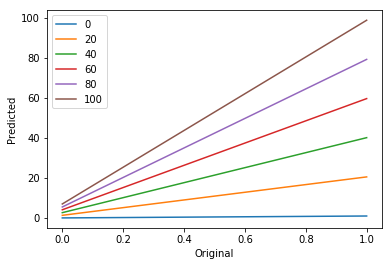

Overall R^2:
0.9454425455618778


In [36]:
preds = pd.DataFrame()
labels = []

uniquex3 = df_train_down['RESULTBINARY'].unique()
for m in range(0, 101):
    
    # Initialize and fit the tree. Set the max depth to 2.
    rfc3 = ensemble.RandomForestClassifier(max_depth=2)
    rfc3.fit(X,Y)
    
    # Get and store predicted values.
    pred = rfc3.predict(X)
    preds['pred{}'.format(m)] = pred
    
    # Residuals.
    y = Y - pred

    # Output every 20 iterations.
    if m % 20 == 0:
        print('Weak learner {} R^2: {}'.format(m, rfc3.score(X, y)))
        labels = labels + [m]
        bestpred = preds.sum(axis=1)
        plt.plot(uniquex3, np.poly1d(np.polyfit(df_train_down['RESULTBINARY'], bestpred, 1))(uniquex3))
       
plt.legend(labels)
plt.xlabel('Original')
plt.ylabel('Predicted')
plt.show()
predicted = preds.sum(axis=1)

print('Overall R^2:')
print(np.corrcoef(df_train_down['RESULTBINARY'], predicted)[0, 1])

---

Decision Tree

In [37]:
dtc = DecisionTreeClassifier(criterion ='entropy', min_samples_split=2, random_state=123456)

dtc_params = [{'max_features': [.25],
              'max_depth': [1, 2, 4, 6, 8]}]


# # Search for the best paramters. 
dtc_grid = GridSearchCV(dtc, dtc_params, cv=5, verbose=1, n_jobs=1)

# Fit the grid and obtain results
dts1 = dtc_grid.fit(X, Y)
dts2 = dtc_grid.predict(X)

# Return best parameters and best score
print('Best parameters Train:')
print(dts1.best_params_)
print('Best Score Train:')
print(dts1.best_score_)

#print('Best Score Test:')
#print(dts2.best_score_)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
Best parameters Train:
{'max_depth': 8, 'max_features': 0.25}
Best Score Train:
0.981549815498155


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:    0.0s finished


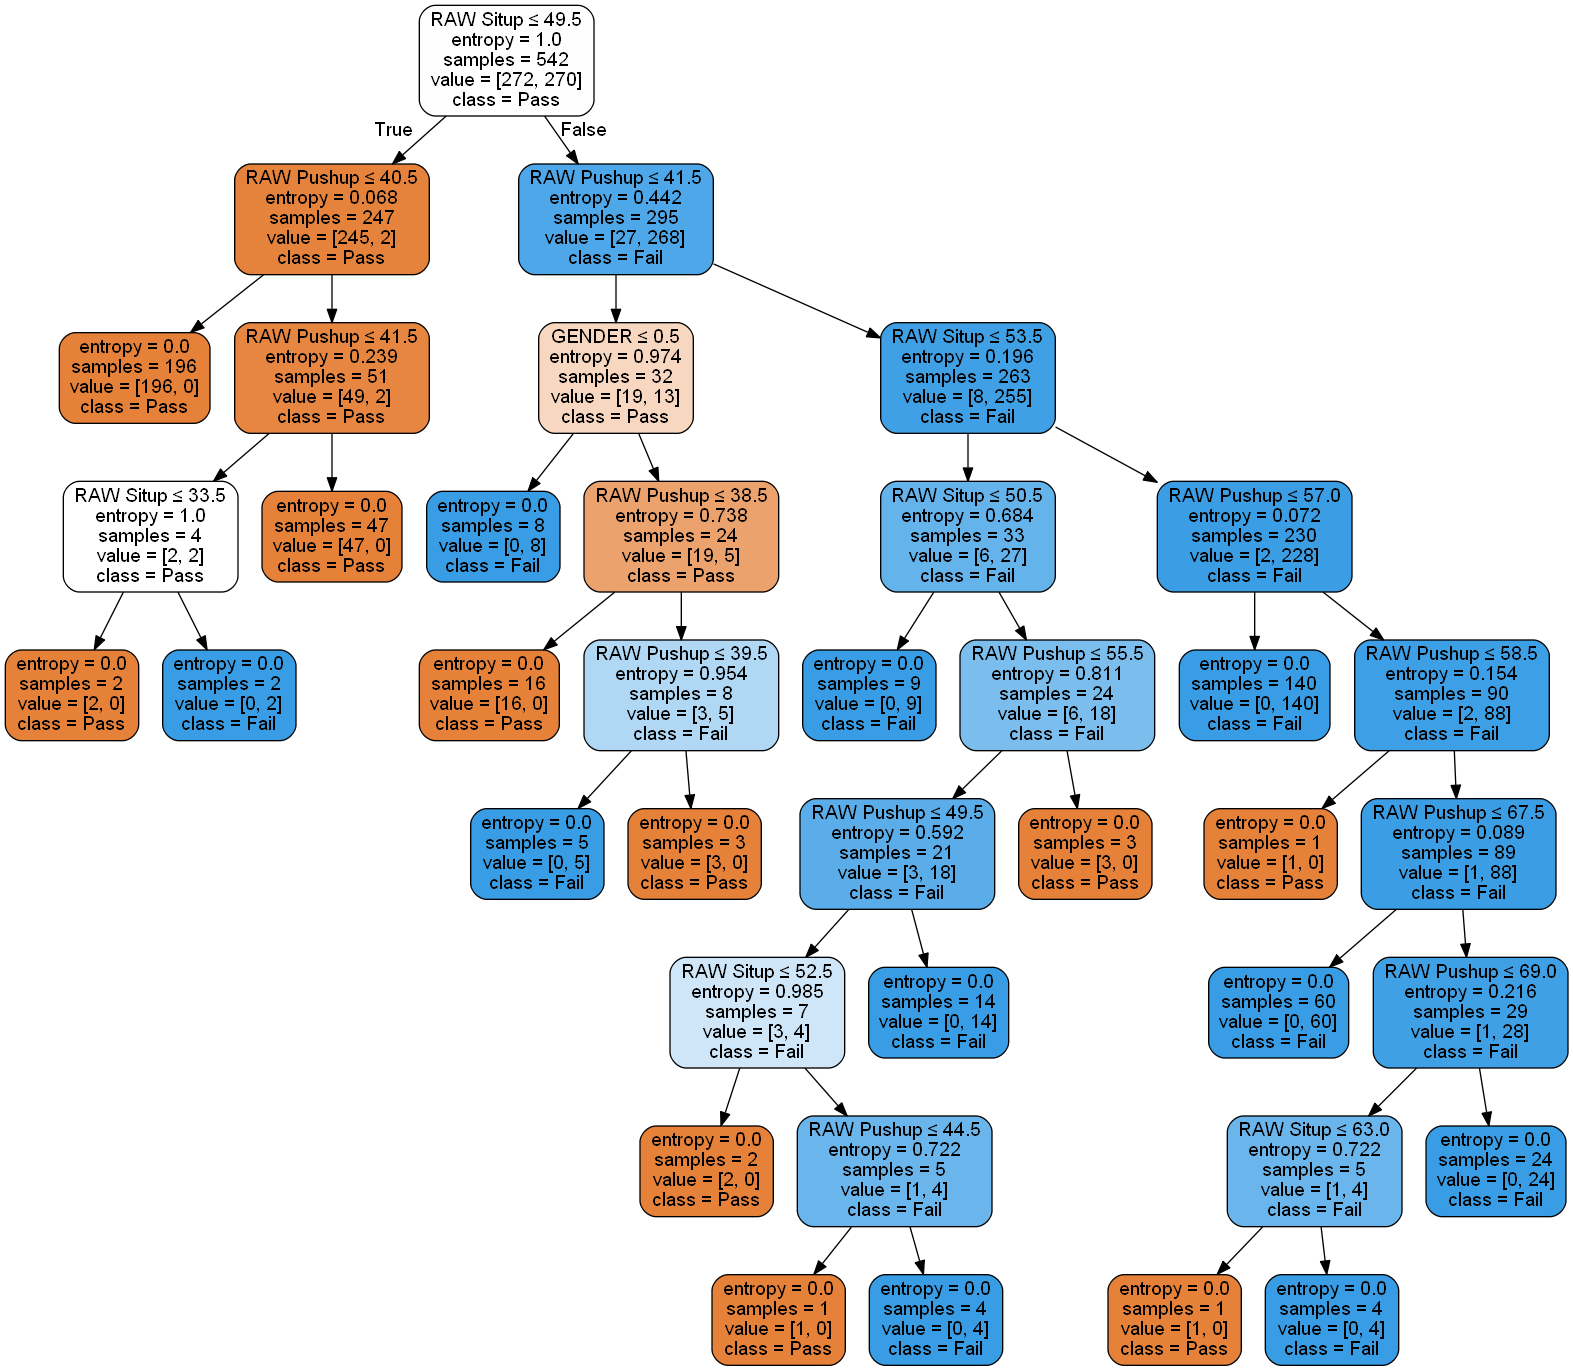

In [38]:
dtc.fit(X, Y)
dot_data = tree.export_graphviz(dtc, 
                                class_names=['Pass', 'Fail'], #Y Columns
                                feature_names=['RAW Pushup', 'RAW Situp', 'GENDER'], #X Columns
                                out_file=None, filled=True, 
                                rounded=True, special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data)
Image(graph.create_png())